In [94]:
import torch
from datasets import load_dataset
import nltk
from collections import Counter
import itertools
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#from gensim.models import Word2Vec


nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)

True

In [2]:
ds = load_dataset("AmazonScience/massive", "fr-FR")
class_name = "scenario"


X_train = ds["train"]["utt"]
Y_train = ds["train"][class_name]
X_test = ds["test"]["utt"]
Y_test = ds["test"][class_name]

In [76]:
#Hyperparameters
h_dim = 100
lr = 5e-4
epochs = 10
batch_size = 25

activation_function = nn.functional.relu

In [117]:
X_train_tokenized = [nltk.word_tokenize(x) for x in X_train]
X_test_tokenized = [nltk.word_tokenize(x) for x in X_test]

#Create the word corpus to create embeddings
corpus = Counter(list(itertools.chain(*X_train_tokenized)))
corpus = sorted(corpus,key=corpus.get,reverse=True) #[:1000]
onehot_dict = {w:i+1 for i,w in enumerate(corpus)}

#Create the embeddings
X_train_embeddings = [[onehot_dict[word] for word in sentence] for sentence in X_train_tokenized]
#We only add the test embeddings if they are in the vocab - this is an issue of the method, unknown words won't be able to have meaning
#We could also give it an arbitrary value, to be tested
X_test_embeddings = [[onehot_dict[word] if word in onehot_dict else len(onehot_dict) for word in sentence] for sentence in X_test_tokenized]

In [5]:
#padding embedding vectors to max sentence length
max_sentence_length = len(max(X_train_embeddings, key=len))
X_train_padded = [np.pad(x, (0, max_sentence_length - len(x)), 'constant', constant_values=(0,0)) for x in X_train_embeddings]

#truncate if needed before padding
X_test_embeddings = [x[:max_sentence_length] for x in X_test_embeddings]
X_test_padded = [np.pad(x, (0, max_sentence_length - len(x)), 'constant', constant_values=(0,0)) for x in X_test_embeddings]

In [6]:
#Load into Tensor format
train_data = TensorDataset(torch.tensor(X_train_padded), torch.tensor(Y_train))
test_data = TensorDataset(torch.tensor(X_test_padded), torch.tensor(Y_test))

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
train_iter = iter(train_loader)

/tmp/ipykernel_9918/4167475810.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_data = TensorDataset(torch.tensor(X_train_padded), torch.tensor(Y_train))


In [7]:
#Model definition
class Feedforward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_function):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation_function = activation_function
    
    def forward(self, text):
        hidden = self.fc1(text.float())
        hidden = self.activation_function(hidden)

        out = self.fc2(hidden)
        return out

In [ ]:
def train(model, dataloader, optim, loss_fun, one_hot_encode=False):
    model.train()
    total_loss = 0
    for sentences, labels in dataloader:
        if one_hot_encode:
            sentences = nn.functional.one_hot(torch.LongTensor(sentences), num_classes=len(onehot_dict) + 1)
            sentences = torch.FloatTensor(sentences)
        optim.zero_grad()
        outputs = model.forward(sentences)
        loss = loss_fun(outputs, labels)
        loss.backward()
        optim.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [9]:
#Function to evaluate a model's predictions. Returns (loss, accuracy)
def evaluate(model, dataloader, loss_fun):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    for sentences, labels in dataloader:
        outputs = model.forward(sentences)
        loss = loss_fun(outputs, labels)
        total_loss += loss.item()

        #Calculate correct predictions for this batch
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += len(predictions)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [10]:
model_base = Feedforward(max_sentence_length, h_dim, 18, activation_function)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_base.parameters(), lr=lr)

for epoch in range (1, epochs + 1):
    loss = train(model_base, train_loader, optimizer, loss_function)
    print(f"Epoch {epoch}: loss = {loss}")
    

KeyboardInterrupt: 

In [11]:
#USING TD-IDF
#tf-idf version of the encoding:
vectorizer = TfidfVectorizer()
X_train_tfidf = torch.Tensor(vectorizer.fit_transform(X_train).toarray())
X_test_tfidf = torch.Tensor(vectorizer.transform(X_test).toarray())

train_data_tfidf = TensorDataset(X_train_tfidf, torch.tensor(Y_train))
test_data_tfidf = TensorDataset(X_test_tfidf, torch.tensor(Y_test))
train_loader_tfidf = DataLoader(train_data_tfidf, shuffle=True, batch_size=batch_size)
test_loader_tfidf = DataLoader(test_data_tfidf, shuffle=True, batch_size=batch_size)

In [21]:
#Train with tf-idf embeddings
model_tfidf = Feedforward(X_train_tfidf.shape[1], h_dim, 18, activation_function)

loss_function_tfidf = nn.CrossEntropyLoss()
optimizer_tfidf = torch.optim.Adam(model_tfidf.parameters(), lr=lr)

for epoch in range (1, epochs + 1):
    loss = train(model_tfidf, train_loader_tfidf ,optimizer_tfidf, loss_function_tfidf)
    print(f"Epoch {epoch}: loss = {loss}")
    

Epoch 1: loss = 2.3736631303961
Epoch 2: loss = 1.2130047086779827
Epoch 3: loss = 0.632274982048736
Epoch 4: loss = 0.3952817688989019
Epoch 5: loss = 0.27669062938969463
Epoch 6: loss = 0.20648739082888254


KeyboardInterrupt: 

In [115]:
loss_tfidf, accuracy_tfidf = evaluate(model_tfidf, test_loader_tfidf, loss_function_tfidf)
print(f"Evaluation with tf_idf: \nLoss = {loss_tfidf}, accuracy = {accuracy_tfidf}")

Evaluation with tf_idf: 
Loss = 0.10494832883623313, accuracy = 0.8863483523873571


In [ ]:
#USING WORD2VEC
word2vec_encoder = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

X_train_data_word2vec = [np.mean([word2vec_encoder.wv[word] for word in x if word in word2vec_encoder.wv]) for x in X_train_tokenized]

X_train_word2vec = torch.Tensor(X_train_data_word2vec)
#X_test_word2vec = torch.Tensor()

train_data_word2vec = TensorDataset(X_train_tfidf, torch.tensor(Y_train))
#test_data_word2vec = TensorDataset(X_test_tfidf, torch.tensor(Y_test))
train_loader_word2vec = DataLoader(train_data_tfidf, shuffle=True, batch_size=batch_size)
#test_loader_word2vec = DataLoader(test_data_tfidf, shuffle=True, batch_size=batch_size)

NameError: name 'Word2Vec' is not defined

In [ ]:
#Train with word2vec embeddings
model_word2vec = Feedforward(100, h_dim, 18, activation_function)

loss_function_word2vec = nn.CrossEntropyLoss()
optimizer_word2vec = torch.optim.Adam(model_word2vec.parameters(), lr=lr)

for epoch in range (1, epochs + 1):
    loss = train(model_word2vec, train_loader_word2vec ,optimizer_word2vec, loss_function_word2vec)
    print(f"Epoch {epoch}: loss = {loss}")
    

In [63]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, bidirectional=False)
        self.h2o = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax()

    def forward(self, text):
        rnn_output, hidden = self.rnn(text)
        out = self.h2o(hidden)
        out = self.softmax(out)
        return out

In [31]:
#Prepare data doing onehot encoding
#X_train_onehots = nn.functional.one_hot(torch.LongTensor(X_train_padded))
#X_test_onehots = nn.functional.one_hot(torch.LongTensor(X_test_padded))

train_data_onehot = TensorDataset(torch.LongTensor(X_train_padded), torch.tensor(Y_train))
#test_data_onehot = TensorDataset(X_test_onehots, torch.tensor(Y_test))
train_loader_onehot = DataLoader(train_data_onehot, shuffle=True, batch_size=batch_size)
#test_loader_onehot = DataLoader(test_data_onehot, shuffle=True, batch_size=batch_size)

In [71]:
import random
import numpy as np

def train_full(rnn, training_data, labels, n_epoch = 10, n_batch_size = 64, report_every = 1, learning_rate = 0.2, criterion = nn.CrossEntropyLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                input_tensor = nn.functional.one_hot(training_data[i], num_classes=len(onehot_dict) + 1)
                output = rnn.forward(input_tensor.float())
                loss = criterion(output[0], labels[i])
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [155]:
rnn = RNN(len(onehot_dict) + 1, h_dim, 18)

losses = train_full(rnn, [torch.tensor(x) for x in X_train_embeddings], torch.tensor(Y_train),n_batch_size=25, learning_rate=0.1, n_epoch=50)

training on data set with n = 11514


/home/luanico/epita/nlp/venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


1 (2%): 	 average batch loss = 2.472912135350664
2 (4%): 	 average batch loss = 2.0011095451814263
3 (6%): 	 average batch loss = 1.731072054936337
4 (8%): 	 average batch loss = 1.513111670318655
5 (10%): 	 average batch loss = 1.369294754647092
6 (12%): 	 average batch loss = 1.2509069336537126
7 (14%): 	 average batch loss = 1.132591946528508
8 (16%): 	 average batch loss = 1.0469787386221234
9 (18%): 	 average batch loss = 0.9638640122493383
10 (20%): 	 average batch loss = 0.887567630407404
11 (22%): 	 average batch loss = 0.8108307805364351
12 (24%): 	 average batch loss = 0.7502864451264862
13 (26%): 	 average batch loss = 0.7109376229841177
14 (28%): 	 average batch loss = 0.6413598623514969
15 (30%): 	 average batch loss = 0.6138460411722452
16 (32%): 	 average batch loss = 0.5703275142385809
17 (34%): 	 average batch loss = 0.5215671843397978
18 (36%): 	 average batch loss = 0.4848785761423338
19 (38%): 	 average batch loss = 0.4632323901286491
20 (40%): 	 average batch loss 

In [153]:
def evaluate_full(rnn, testing_data, labels, labels_tensor, classes):
    confusion = torch.zeros(len(classes), len(classes))
    total = 0
    correct = 0

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            input_tensor = nn.functional.one_hot(testing_data[i], num_classes=len(onehot_dict) + 1)
            output = rnn(input_tensor.float())
            guess_i = torch.argmax(output).item()
            label_i = classes.index(labels[i])
            confusion[label_i][guess_i] += 1
            if guess_i == label_i:
                correct += 1
            total += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()
    return correct / total

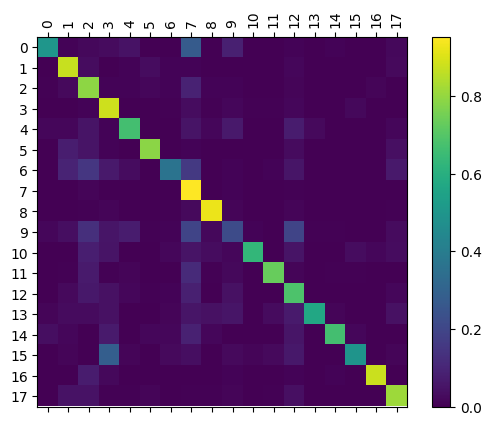

Evaluation with rnn: accuracy = 0.7360457296570275


In [156]:
_SCENARIOS = ['social', 'transport', 'calendar', 'play', 'news', 'datetime', 'recommendation', 'email',
              'iot', 'general', 'audio', 'lists', 'qa', 'cooking', 'takeaway', 'music', 'alarm', 'weather']

#test_in =  nn.functional.one_hot(torch.LongTensor(X_test_embeddings[5]), num_classes=len(onehot_dict) + 1)
#label_from_output(rnn(test_in.float()), list(range(18)))

accuracy_rnn = evaluate_full(rnn, [torch.LongTensor(x) for x in X_test_embeddings], Y_test, torch.tensor(Y_test), list(range(18)))

print(f"Evaluation with rnn: accuracy = {accuracy_rnn}")